In [6]:
import numpy as np
import math
import cv2
import pickle

from sklearn.linear_model import LinearRegression, Ridge
#from sklearn.linear_model import LinearRegression

from matplotlib import pyplot as plt

In [7]:
#Function Definitions

def DoG_on_parasol_bipolars(r, amp):
    a_cent = 1
    a_sur = 0.01
    sig_cent = 4
    sig_sur = sig_cent * 9
    DoG = a_cent * math.e**(-(r**2)/(2*sig_cent**2)) - a_sur * math.e**(-(r**2)/(2*sig_sur**2))
    return DoG*amp

def DoG_on_parasol(r, amp):
    a_cent = 1
    a_sur = 0.375
    sig_cent = 10
    sig_sur = sig_cent * 1.15
    DoG = a_cent * math.e**(-(r**2)/(2*sig_cent**2)) - a_sur * math.e**(-(r**2)/(2*sig_sur**2))
    return DoG*amp

def simulate(cone_array):
    
    #RGC matrices
    on_parasol_responses = np.zeros((64,64))


    #Bipolar matrices
    on_parasol_bipolar_responses = np.zeros((256,256))


    #Cone matrices
    #cone_responses = np.zeros((256,256))
    cone_responses = np.copy(cone_array)
    
    # get cone responses from image, now just given as input
    #cone_responses = image * (0.0001/255.0) #grayscale 0 to 0.0001 
    
    
    
    # get bipolar responses from cone outputs

    # scale up by 11 (10 microns each axis = 5 neurons each way, this means we have 11x11 cones feeding into each bipolar
    # including the cone directly on top of the bipolar)

    i=0
    j=0
    while(i<np.shape(on_parasol_bipolar_responses)[0]):
        while(j<np.shape(on_parasol_bipolar_responses)[1]):

            a_init = 0
            b_init = 0
            a_max = 11
            b_max = 11

            if(j<5):
                b_init=5-j #only can go over to 0th col of cones
            if(i<5):
                a_init=5-i #only can go over to 0th row of cones
            if(j>250):
                b_max=6+(255-j) #only can go over to 255th col of cones
            if(i>250):
                a_max=6+(255-i) #only can go over to 255th row of cones

            a=a_init
            b=b_init
            while(a < a_max):
                while(b < b_max):
                    #scale up and get radii:
                    r = math.sqrt(((a-5)**2) + ((b-5)**2))

                    #get scaled up response:
                    in_resp = cone_responses[i+(a-5),j+(b-5)]
                    resp = DoG_on_parasol_bipolars(r, in_resp)

                    #scale back down by summing:
                    on_parasol_bipolar_responses[i,j] += resp

                    b+=1
                b=b_init
                a+=1

            j+=1
        j=0
        i+=1
    
    #temporal response


    #Since golden paper didn't give any information on the temporal filter (and we are using slightly different
    #temporal modeling with single frame of picture shown then nothing for the rest of the 0.4 s), we will use
    #exponential decay to model the temporal behavior with the initial value starting at the spacial response
    #and the decay value to be 50 (0.02s half life of neuron response strength, close to curve of golden
    #temporal response)

    #response = init_response * e^(decay_val*t)

    decay_val = -50


    #on parasol temporal:

    initial_on_parasol_bipolar_responses = np.copy(on_parasol_bipolar_responses)

    t=0.001 #time steps of 0.001s (400 time periods)
    while t<0.4: #simulate 0.4s like golden paper did
        i=0
        j=0
        while(i<np.shape(on_parasol_bipolar_responses)[0]):
            while(j<np.shape(on_parasol_bipolar_responses)[1]):
                #calculate current time's temporal response value with exponential decay equation, then add it
                #to the overall bipolar response

                init_response = initial_on_parasol_bipolar_responses[i,j]

                response = init_response * math.e**(decay_val*t)

                on_parasol_bipolar_responses[i,j] += response #sum over temporal response for each neuron

                j+=1
            i+=1

        t+=0.001
    
    # get rgc responses from bipolars

    # scale up by 32 from rgc matrix (need 25 microns/axis ~12 neurons each way, means we have 25x25 bipolars feeding each
    # rgc including the bipolar directly on top of the rgc)
    # we need our scaling factor to be a multiple of 4 though (which ignores symmetry), so we will scale by 32x32
    # so that despite assymetry, the value we are losing are essentially 0
    
    i=0
    j=0
    while(i<np.shape(on_parasol_responses)[0]):
        while(j<np.shape(on_parasol_responses)[1]):

            a_init = 0
            b_init = 0
            a_max = 32
            b_max = 32

            if(j*4<16):
                b_init=16-j*4 #only can go over to 0th col of bipolars
            if(i*4<16):
                a_init=16-i*4 #only can go over to 0th row of bipolars
            if(j*4>239):
                b_max=16+(255-j*4) #only can go over to 255th col of bipolars
            if(i*4>239):
                a_max=16+(255-i*4) #only can go over to 255th row of bipolars

            a=a_init
            b=b_init
            while(a < a_max):
                while(b < b_max):

                    #scale up and get radii:
                    r = math.sqrt(((a-16)**2) + ((b-16)**2))

                    #get scaled up response:
                    in_resp = on_parasol_bipolar_responses[i*4+(a-16),j*4+(b-16)]
                    resp = DoG_on_parasol(r, in_resp)

                    #scale baack down by summing:
                    on_parasol_responses[i,j] += resp

                    b+=1
                b=b_init
                a+=1

            j+=1
        j=0
        i+=1
    
    
    #convert response to firing rate


    #go through all rgc responses and convert response to firing rate

    #we'll use an exponential function to get spike rate from rgc response (golden got this from pillow et al 2008)
    #large rgc response is 1.1, so exponential goes from e^0=1 to e^1.2=3.00
    #6 Hz seems to be a large neuron firing rate for an RGC (from other studies), so we'll use this as max_rate
    #exponential function: firing_rate = max_rate*((e^(response)-1)/2.00)
    #subtract 1 from exponential so we have values starting from 0 to 2.00, divide by 2.00 and multiply by max rate so
    #large responses will be about equal to our inputted max firing rate (maybe slightly larger)

    max_rate = 6 #6Hz seems to be a very large RGC firing rate

    #hopefully the learned reconstruction matrix will be able to compensate for any differences we've made in
    #our equations (as long as we use the same equations here and in learning)


    #on parasol rgcs:

    i=0
    j=0
    while(i<np.shape(on_parasol_responses)[0]):
        while(j<np.shape(on_parasol_responses)[1]):
            response = on_parasol_responses[i,j]

            firing_rate = max_rate*((math.e**(response)-1)/2)

            if(firing_rate < 0):
                firing_rate = 0

            on_parasol_responses[i,j] = firing_rate

            j+=1
        j=0
        i+=1
    
    return on_parasol_responses

In [60]:
#electrode functions

def G_electrodes(r, amp):
    sigma = 35
    G = 1/(2*math.pi*sigma**2) * math.e**(-(r**2)/(2*sigma**2))
    #G = 1 * math.e**(-(r**2)/(2*sigma**2)) # G with amplitude 1
    return G*amp

def simulate_electrodes(electrode_voltages):
    
    #RGC matrices
    on_parasol_responses = np.zeros((64,64))


    #Bipolar matrices
    on_parasol_bipolar_responses = np.zeros((256,256))


    #Electrodes
    #electrode_voltages = np.zeros((8,8))
    
    electrode_help = np.zeros((256,256)) #scaled up electrodes
    
    #place elctrodes on scaled up electrode grid
    i=0
    j=0
    while(i<np.shape(electrode_voltages)[0]):
        while(j<np.shape(electrode_voltages)[1]):
            
            electrode_help[i*32+16, j*32+16] = electrode_voltages[i,j]
            
            j+=1
        j=0
        i+=1
    
    
    # get bipolar responses from electrode outputs

    # scale up by 64 (64 microns each axis = ~32 neurons each way, electrode feeds into surrounding 64x64 bipolars)

    i=0
    j=0
    while(i<np.shape(on_parasol_bipolar_responses)[0]):
        while(j<np.shape(on_parasol_bipolar_responses)[1]):

            a_init = 0
            b_init = 0
            a_max = 32
            b_max = 32

            if(j<16):
                b_init=16-j #only can go over to 0th col of bipolars
            if(i<16):
                a_init=16-i #only can go over to 0th row of bipolars
            if(j>239):
                b_max=16+(255-j) #only can go over to 255th col of bipolars
            if(i>239):
                a_max=16+(255-i) #only can go over to 255th row of bipolars

            a=a_init
            b=b_init
            while(a < a_max):
                while(b < b_max):
                    #scale up and get radii:
                    r = math.sqrt(((a-16)**2) + ((b-16)**2))

                    #get scaled up response:
                    in_resp = electrode_help[i+(a-16),j+(b-16)]
                    resp = G_electrodes(r, in_resp)

                    #scale back down by summing:
                    on_parasol_bipolar_responses[i,j] += resp

                    b+=1
                b=b_init
                a+=1

            j+=1
        j=0
        i+=1
    
    
    #temporal response


    #Since golden paper didn't give any information on the temporal filter (and we are using slightly different
    #temporal modeling with single frame of picture shown then nothing for the rest of the 0.4 s), we will use
    #exponential decay to model the temporal behavior with the initial value starting at the spacial response
    #and the decay value to be 50 (0.02s half life of neuron response strength, close to curve of golden
    #temporal response)

    #response = init_response * e^(decay_val*t)

    decay_val = -50


    #on parasol temporal:

    initial_on_parasol_bipolar_responses = np.copy(on_parasol_bipolar_responses)

    t=0.001 #time steps of 0.001s (400 time periods)
    while t<0.4: #simulate 0.4s like golden paper did
        i=0
        j=0
        while(i<np.shape(on_parasol_bipolar_responses)[0]):
            while(j<np.shape(on_parasol_bipolar_responses)[1]):
                #calculate current time's temporal response value with exponential decay equation, then add it
                #to the overall bipolar response

                init_response = initial_on_parasol_bipolar_responses[i,j]

                response = init_response * math.e**(decay_val*t)

                on_parasol_bipolar_responses[i,j] += response #sum over temporal response for each neuron

                j+=1
            i+=1

        t+=0.001
    
    # get rgc responses from bipolars

    # scale up by 32 from rgc matrix (need 25 microns/axis ~12 neurons each way, means we have 25x25 bipolars feeding each
    # rgc including the bipolar directly on top of the rgc)
    # we need our scaling factor to be a multiple of 4 though (which ignores symmetry), so we will scale by 32x32
    # so that despite assymetry, the value we are losing are essentially 0
    
    i=0
    j=0
    while(i<np.shape(on_parasol_responses)[0]):
        while(j<np.shape(on_parasol_responses)[1]):

            a_init = 0
            b_init = 0
            a_max = 32
            b_max = 32

            if(j*4<16):
                b_init=16-j*4 #only can go over to 0th col of bipolars
            if(i*4<16):
                a_init=16-i*4 #only can go over to 0th row of bipolars
            if(j*4>239):
                b_max=16+(255-j*4) #only can go over to 255th col of bipolars
            if(i*4>239):
                a_max=16+(255-i*4) #only can go over to 255th row of bipolars

            a=a_init
            b=b_init
            while(a < a_max):
                while(b < b_max):

                    #scale up and get radii:
                    r = math.sqrt(((a-16)**2) + ((b-16)**2))

                    #get scaled up response:
                    in_resp = on_parasol_bipolar_responses[i*4+(a-16),j*4+(b-16)]
                    resp = DoG_on_parasol(r, in_resp)

                    #scale baack down by summing:
                    on_parasol_responses[i,j] += resp

                    b+=1
                b=b_init
                a+=1

            j+=1
        j=0
        i+=1
    
    
    #convert response to firing rate


    #go through all rgc responses and convert response to firing rate

    #we'll use an exponential function to get spike rate from rgc response (golden got this from pillow et al 2008)
    #large rgc response is 1.1, so exponential goes from e^0=1 to e^1.2=3.00
    #6 Hz seems to be a large neuron firing rate for an RGC (from other studies), so we'll use this as max_rate
    #exponential function: firing_rate = max_rate*((e^(response)-1)/2.00)
    #subtract 1 from exponential so we have values starting from 0 to 2.00, divide by 2.00 and multiply by max rate so
    #large responses will be about equal to our inputted max firing rate (maybe slightly larger)

    max_rate = 6 #6Hz seems to be a very large RGC firing rate

    #hopefully the learned reconstruction matrix will be able to compensate for any differences we've made in
    #our equations (as long as we use the same equations here and in learning)


    #on parasol rgcs:

    i=0
    j=0
    while(i<np.shape(on_parasol_responses)[0]):
        while(j<np.shape(on_parasol_responses)[1]):
            response = on_parasol_responses[i,j]

            firing_rate = max_rate*((math.e**(response)-1)/2)

            if(firing_rate < 0):
                firing_rate = 0

            on_parasol_responses[i,j] = firing_rate

            j+=1
        j=0
        i+=1
    
    return on_parasol_responses

In [56]:
row = imgs['data'][0]

image_validation = row.reshape((64,64,3), order='F').transpose(1,0,2)
gray_image_validation = cv2.cvtColor(image_validation, cv2.COLOR_BGR2GRAY)
resized_validation = cv2.resize(gray_image_validation, (256,256), interpolation = cv2.INTER_AREA)

cone_array_validation = resized_validation * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
#response_validation = simulate(cone_array_validation)

resized_voltages = cv2.resize(gray_image_validation, (8,8), interpolation = cv2.INTER_AREA)

voltage_validation = resized_voltages * (50/255.0) #grayscale 0 to 50, electrode set up to have voltages up to 50V
elec_validation = simulate_electrodes(voltage_validation)


0
50
100
150
200
250
temporal


In [3]:
#path = 'C:/Users/rhyst/Downloads/'
#name = 'test_image.png'
#image = cv2.imread(path+name, cv2.IMREAD_GRAYSCALE)
#cone_array = image * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
#tmp = simulate(cone_array)

In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo)
    return dict

imgs = unpickle('D:/ImageNet/Imagenet64_train_part1/train_data_batch_1')
imgs['data'].shape

(128116, 12288)

In [17]:
#reformatting imagenet images

#from matplotlib import pyplot as plt

test_imgs_tmp = np.copy(imgs['data'][0:500])
test_imgs = np.zeros((500,256*256))
retina_responses = np.zeros((500,64*64))


#tmp = test_imgs_tmp[0].reshape((64,64,3), order='F').transpose(1,0,2)
#gray = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
#resized = cv2.resize(gray, (256,256), interpolation = cv2.INTER_AREA)
#cone_array = resized * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
#response = simulate(cone_array)

i=0
for row in test_imgs_tmp:
    image = row.reshape((64,64,3), order='F').transpose(1,0,2)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray_image, (256,256), interpolation = cv2.INTER_AREA)
    test_imgs[i] = resized.reshape(256*256)
    
    cone_array = resized * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
    response = simulate(cone_array)
    retina_responses[i] = response.reshape(64*64)
    i+=1



In [7]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(retina_responses[0:499], test_imgs[0:499])
test_output = reg.predict(retina_responses[499].reshape((1,64*64)))


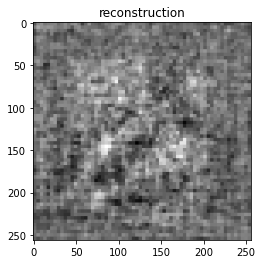

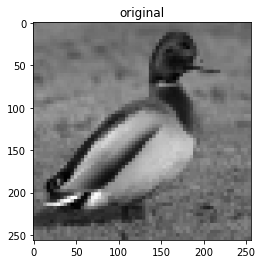

In [8]:
from matplotlib import pyplot as plt
plt.imshow(test_output[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs[499].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

In [14]:
test_imgs_tmp_validation = np.copy(imgs['data'][500:510])
test_imgs_validation = np.zeros((10,256*256))
retina_responses_validation = np.zeros((10,64*64))

i=0
for row in test_imgs_tmp_validation:
    image_validation = row.reshape((64,64,3), order='F').transpose(1,0,2)
    gray_image_validation = cv2.cvtColor(image_validation, cv2.COLOR_BGR2GRAY)
    resized_validation = cv2.resize(gray_image_validation, (256,256), interpolation = cv2.INTER_AREA)
    test_imgs_validation[i] = resized_validation.reshape(256*256)
    
    cone_array_validation = resized_validation * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
    response_validation = simulate(cone_array_validation)
    retina_responses_validation[i] = response_validation.reshape(64*64)
    i+=1



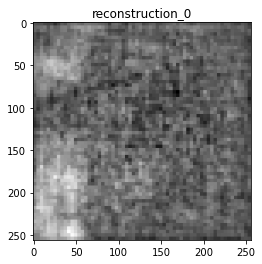

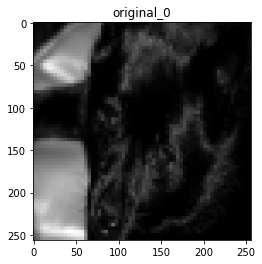

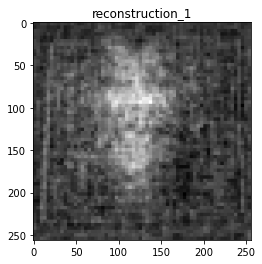

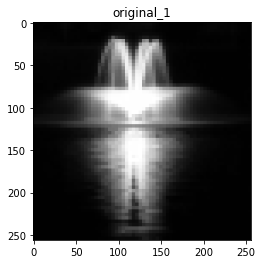

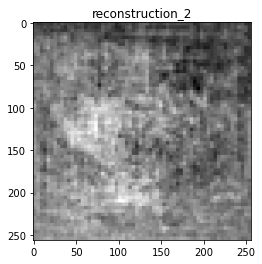

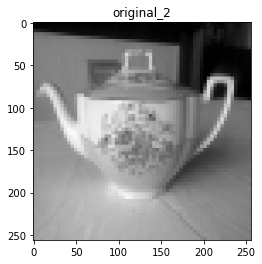

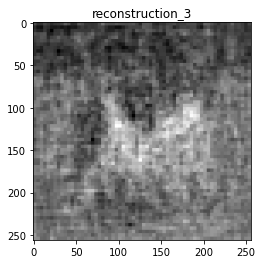

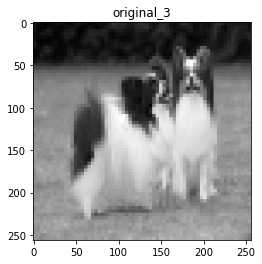

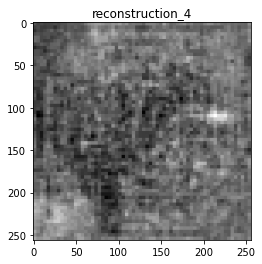

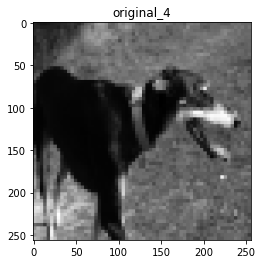

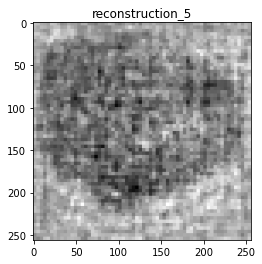

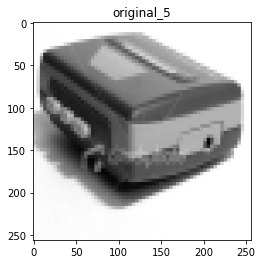

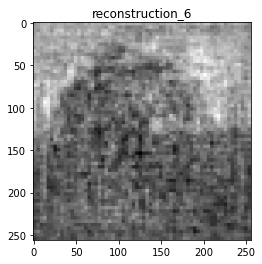

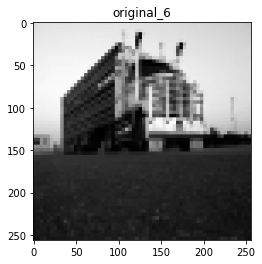

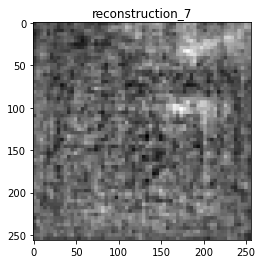

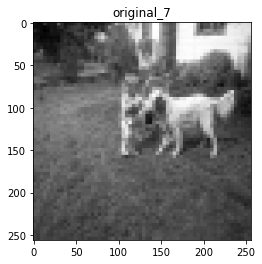

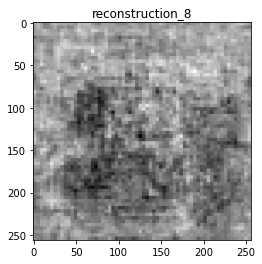

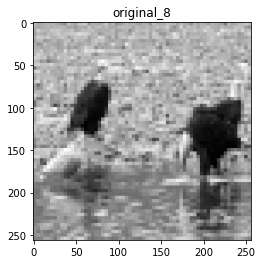

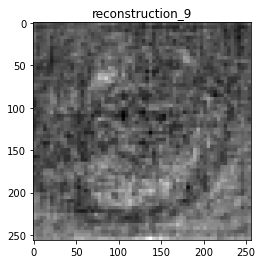

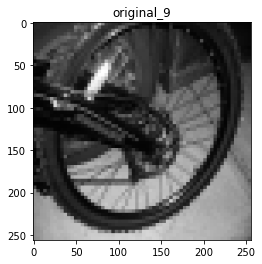

In [13]:
i=0
while i<10:
    test_output_validation = reg.predict(retina_responses_validation[i].reshape((1,64*64)))

    plt.imshow(test_output_validation[0].reshape((256,256)), cmap='gray')
    plt.title('reconstruction_'+str(i))
    plt.show()

    plt.imshow(test_imgs_validation[i].reshape((256,256)), cmap='gray')
    plt.title('original_'+str(i))
    plt.show()
    
    i+=1

In [15]:
test_imgs_tmp_2 = np.copy(imgs['data'][500:1000])
test_imgs_2 = np.zeros((500,256*256))
retina_responses_2 = np.zeros((500,64*64))

i=0
for row in test_imgs_tmp_2:
    image_2 = row.reshape((64,64,3), order='F').transpose(1,0,2)
    gray_image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
    resized_2 = cv2.resize(gray_image_2, (256,256), interpolation = cv2.INTER_AREA)
    test_imgs_2[i] = resized_2.reshape(256*256)
    
    cone_array_2 = resized_2 * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
    response_2 = simulate(cone_array_2)
    retina_responses_2[i] = response_2.reshape(64*64)
    i+=1


In [18]:
retina_responses_1000 = np.concatenate((retina_responses, retina_responses_2))
test_imgs_1000 = np.concatenate((test_imgs, test_imgs_2))

reg_1000 = LinearRegression().fit(retina_responses_1000[0:999], test_imgs_1000[0:999])
test_output = reg_1000.predict(retina_responses_1000[999].reshape((1,64*64)))

plt.imshow(test_output[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs_1000[999].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

In [26]:
test_imgs_tmp_validation_1000 = np.copy(imgs['data'][1000:1010])
test_imgs_validation_1000 = np.zeros((10,256*256))
retina_responses_validation_1000 = np.zeros((10,64*64))

i=0
for row in test_imgs_tmp_validation_1000:
    image_validation_1000 = row.reshape((64,64,3), order='F').transpose(1,0,2)
    gray_image_validation_1000 = cv2.cvtColor(image_validation_1000, cv2.COLOR_BGR2GRAY)
    resized_validation_1000 = cv2.resize(gray_image_validation_1000, (256,256), interpolation = cv2.INTER_AREA)
    test_imgs_validation_1000[i] = resized_validation_1000.reshape(256*256)
    
    cone_array_validation_1000 = resized_validation_1000 * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
    response_validation_1000 = simulate(cone_array_validation_1000)
    retina_responses_validation_1000[i] = response_validation_1000.reshape(64*64)
    i+=1


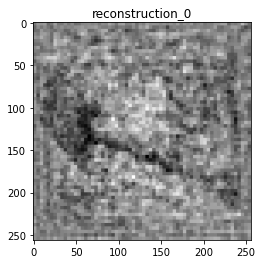

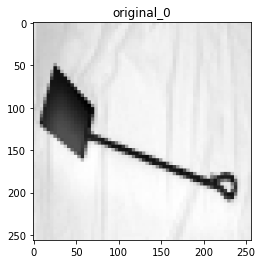

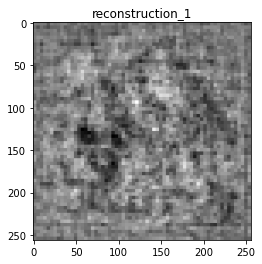

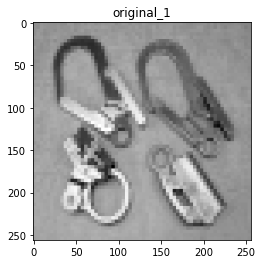

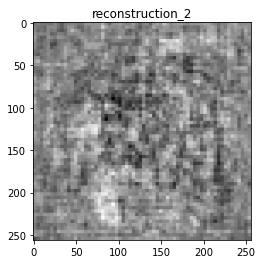

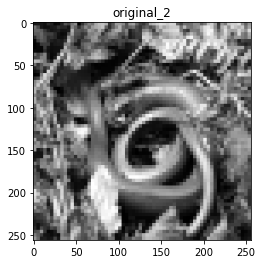

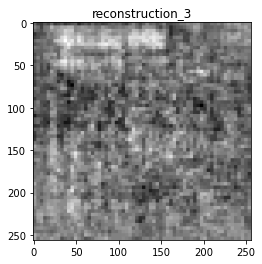

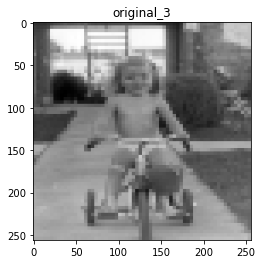

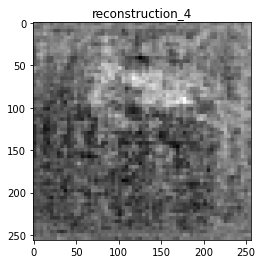

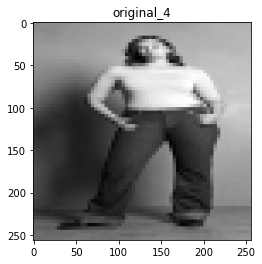

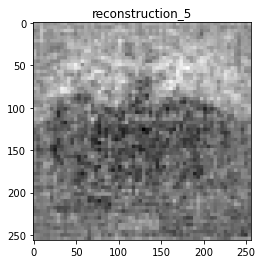

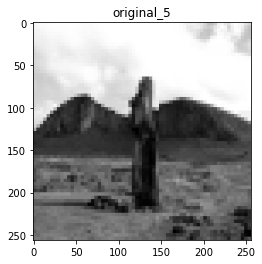

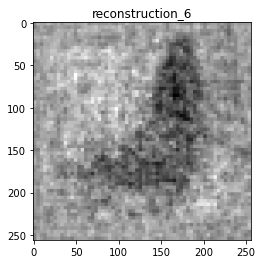

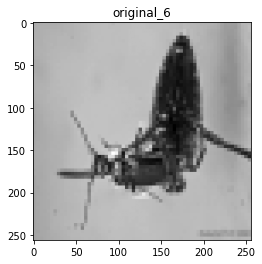

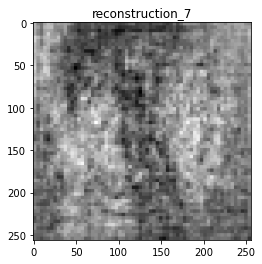

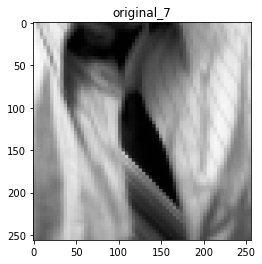

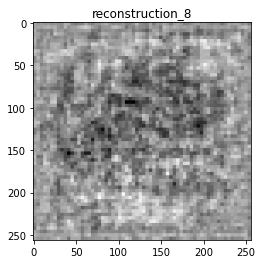

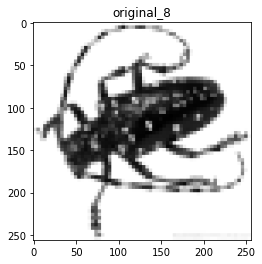

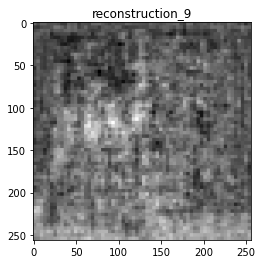

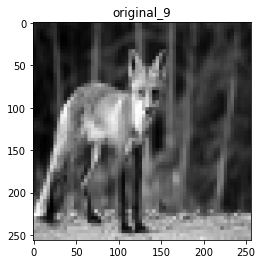

In [27]:
i=0
while i<10:
    test_output_validation_1000 = reg_1000.predict(retina_responses_validation_1000[i].reshape((1,64*64)))

    plt.imshow(test_output_validation_1000[0].reshape((256,256)), cmap='gray')
    plt.title('reconstruction_'+str(i))
    plt.show()

    plt.imshow(test_imgs_validation_1000[i].reshape((256,256)), cmap='gray')
    plt.title('original_'+str(i))
    plt.show()
    
    i+=1

In [13]:
test_imgs_tmp_3 = np.copy(imgs['data'][1000:2000])
test_imgs_3 = np.zeros((1000,256*256))
retina_responses_3 = np.zeros((1000,64*64))

i=0
for row in test_imgs_tmp_3:
    image_3 = row.reshape((64,64,3), order='F').transpose(1,0,2)
    gray_image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2GRAY)
    resized_3 = cv2.resize(gray_image_3, (256,256), interpolation = cv2.INTER_AREA)
    test_imgs_3[i] = resized_3.reshape(256*256)
    
    cone_array_3 = resized_3 * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
    response_3 = simulate(cone_array_3)
    retina_responses_3[i] = response_3.reshape(64*64)
    i+=1


In [19]:
retina_responses_2000 = np.concatenate((retina_responses_1000, retina_responses_3))
test_imgs_2000 = np.concatenate((test_imgs_1000, test_imgs_3))

reg_2000 = LinearRegression().fit(retina_responses_2000[0:1999], test_imgs_2000[0:1999])
test_output = reg_2000.predict(retina_responses_2000[1999].reshape((1,64*64)))

plt.imshow(test_output[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs_2000[1999].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

In [62]:
retina_responses_1500 = np.concatenate((retina_responses_1000, retina_responses_3[0:500]))
test_imgs_1500 = np.concatenate((test_imgs_1000, test_imgs_3[0:500]))

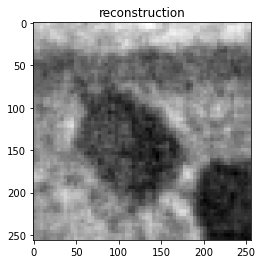

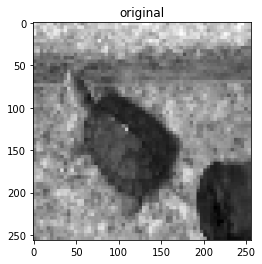

In [26]:

#reg_1500 = LinearRegression().fit(retina_responses_1500[0:1499], test_imgs_1500[0:1499])
#test_output = reg_1500.predict(retina_responses_1500[1499].reshape((1,64*64)))

ridge_2000 = Ridge().fit(retina_responses_2000[0:1999], test_imgs_2000[0:1999])
test_output_ridge = ridge_2000.predict(retina_responses_2000[1999].reshape((1,64*64)))

plt.imshow(test_output_ridge[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs_2000[1999].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

In [27]:
test_imgs_tmp_validation_2000 = np.copy(imgs['data'][2000:2010])
test_imgs_validation_2000 = np.zeros((10,256*256))
retina_responses_validation_2000 = np.zeros((10,64*64))

i=0
for row in test_imgs_tmp_validation_2000:
    image_validation_2000 = row.reshape((64,64,3), order='F').transpose(1,0,2)
    gray_image_validation_2000 = cv2.cvtColor(image_validation_2000, cv2.COLOR_BGR2GRAY)
    resized_validation_2000 = cv2.resize(gray_image_validation_2000, (256,256), interpolation = cv2.INTER_AREA)
    test_imgs_validation_2000[i] = resized_validation_2000.reshape(256*256)
    
    cone_array_validation_2000 = resized_validation_2000 * (0.0001/255.0) #grayscale 0 to 0.0001, cones set up to have responses up to 0.0001
    response_validation_2000 = simulate(cone_array_validation_2000)
    retina_responses_validation_2000[i] = response_validation_2000.reshape(64*64)
    i+=1


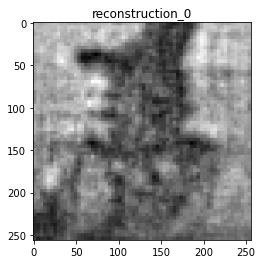

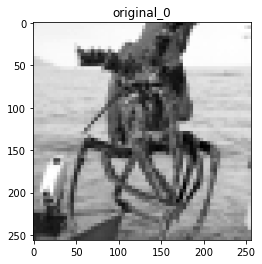

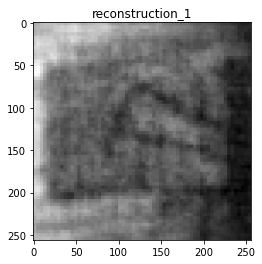

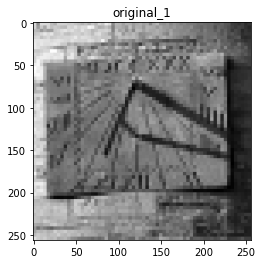

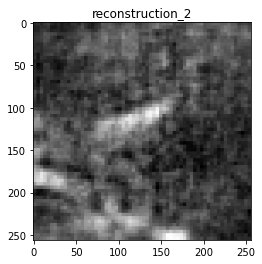

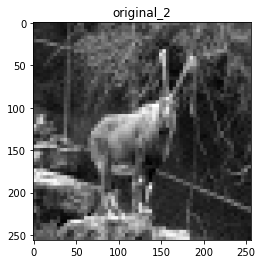

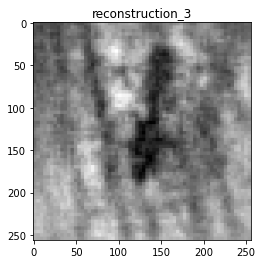

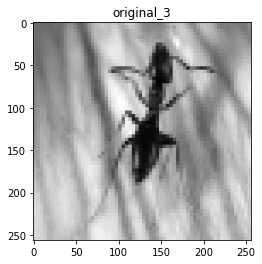

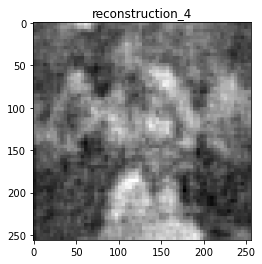

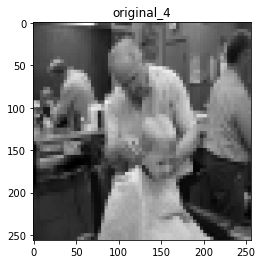

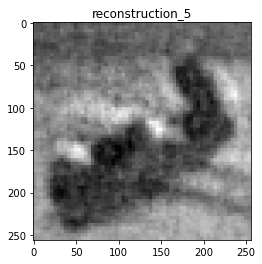

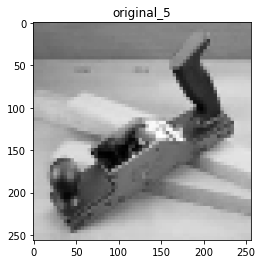

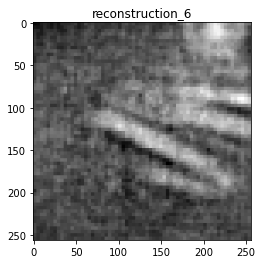

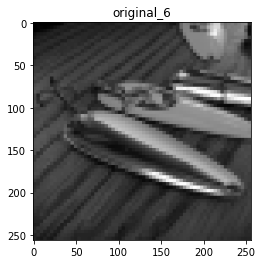

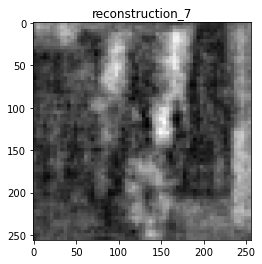

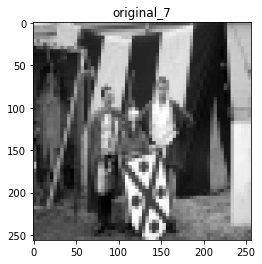

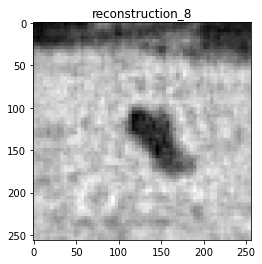

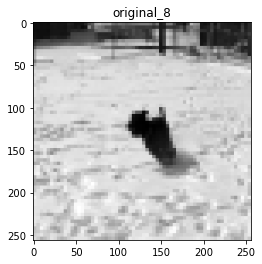

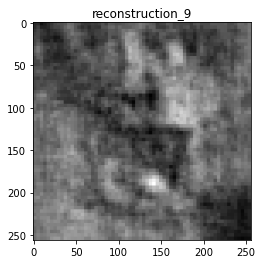

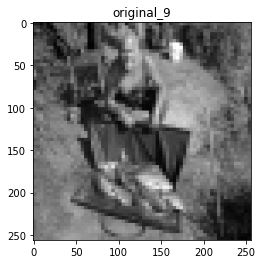

In [28]:
i=0
while i<10:
    test_output_validation = ridge_2000.predict(retina_responses_validation_2000[i].reshape((1,64*64)))

    plt.imshow(test_output_validation[0].reshape((256,256)), cmap='gray')
    plt.title('reconstruction_'+str(i))
    plt.show()

    plt.imshow(test_imgs_validation_2000[i].reshape((256,256)), cmap='gray')
    plt.title('original_'+str(i))
    plt.show()
    
    i+=1

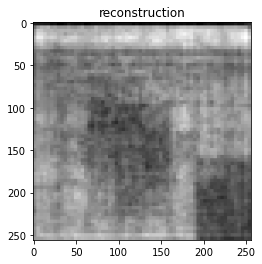

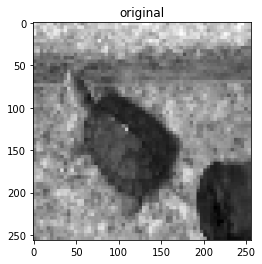

In [65]:
voltages_test = cv2.resize(test_imgs_2000[1999].reshape(256,256), (8,8), interpolation = cv2.INTER_AREA)

voltage_validation = voltages_test * (50/255.0) #grayscale 0 to 50, electrode set up to have voltages up to 50V
elec_validation = simulate_electrodes(voltage_validation)

electrode_output_ridge = ridge_2000.predict(elec_validation.reshape((1,64*64)))

plt.imshow(electrode_output_ridge[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs_2000[1999].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

In [20]:
#save test images so I can restart python

#fileName = 'C:/Users/rhyst/Documents/CS291A/Pickles/test_imgs_2000'
#fileObject = open(fileName, 'wb')
#pickle.dump(test_imgs_2000, fileObject)
#fileObject.close()

In [21]:
#load test images from pickle

fileName = 'C:/Users/rhyst/Documents/CS291A/Pickles/test_imgs_2000'
fileObject = open(fileName, 'rb')
tmp = pickle.load(fileObject)
fileObject.close()

In [ ]:
#save retina responses so I can restart python

#fileName = 'C:/Users/rhyst/Documents/CS291A/Pickles/retina_responses_2000'
#fileObject = open(fileName, 'wb')
#pickle.dump(retina_responses_2000, fileObject)
#fileObject.close()

In [24]:
#load retina responses from pickle

fileName = 'C:/Users/rhyst/Documents/CS291A/Pickles/retina_responses_2000'
fileObject = open(fileName, 'rb')
retina_responses_2000 = pickle.load(fileObject)
fileObject.close()

In [63]:
print(test_imgs_1000.size*retina_responses_1000.itemsize)
del test_imgs_1000

524288000


In [65]:
print(test_imgs.size*test_imgs.itemsize)
del test_imgs

262144000


In [5]:
print("old size")
print(imgs['data'].size*imgs['data'].itemsize)
print(imgs['data'].shape)
imgs['data'] = imgs['data'][0:10000] #cut imgs down to only 10,000 entries
print("-------")
print("new size")
print(imgs['data'].size*imgs['data'].itemsize)
print(imgs['data'].shape)

old size
1574289408
(128116, 12288)
-------
new size
122880000
(10000, 12288)


In [69]:
import gc
gc.collect(0)
gc.collect(1)
gc.collect(2)

18

In [70]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                test_imgs_1500: 750.0 MiB
                   test_imgs_3: 500.0 MiB
                   test_imgs_2: 250.0 MiB
         retina_responses_1500: 46.9 MiB
         retina_responses_1000: 31.3 MiB
            retina_responses_3: 31.3 MiB
              retina_responses: 15.6 MiB
            retina_responses_2: 15.6 MiB
               test_imgs_tmp_3: 11.7 MiB
                 test_imgs_tmp:  5.9 MiB


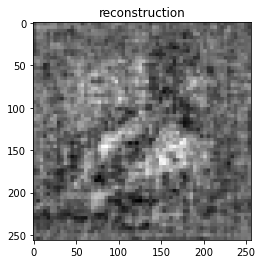

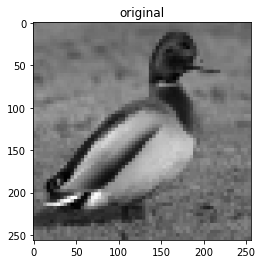

In [18]:
#another option for a regressor, seems to be a little better
from sklearn.linear_model import Ridge

ridge = Ridge().fit(retina_responses[0:499], test_imgs[0:499])
test_output_ridge = ridge.predict(retina_responses[499].reshape((1,64*64)))

plt.imshow(test_output_ridge[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs[499].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

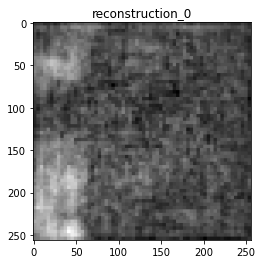

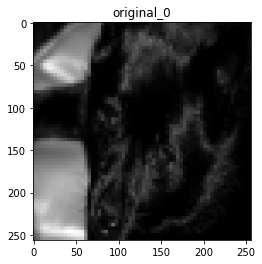

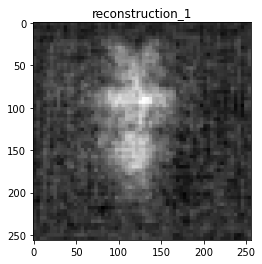

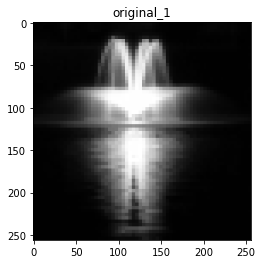

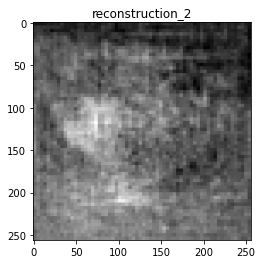

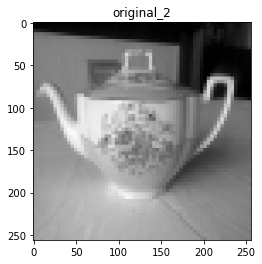

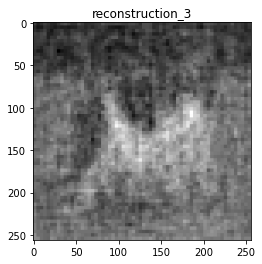

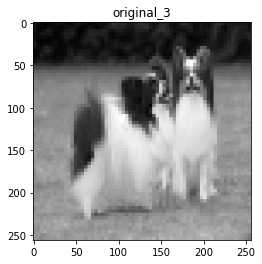

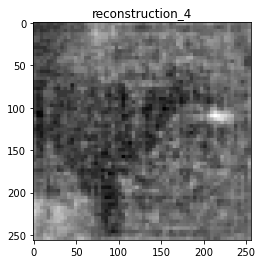

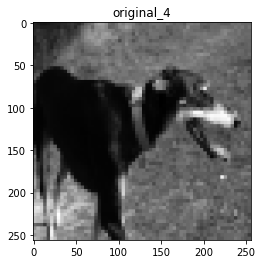

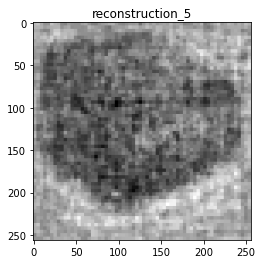

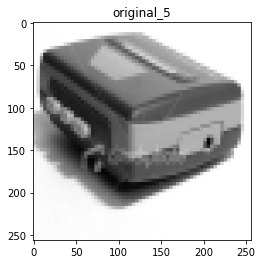

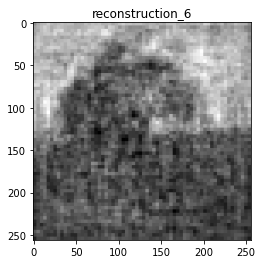

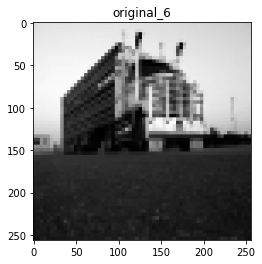

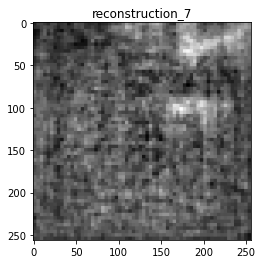

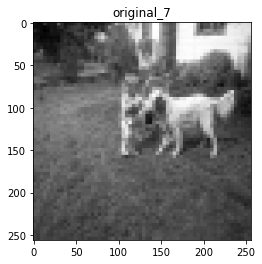

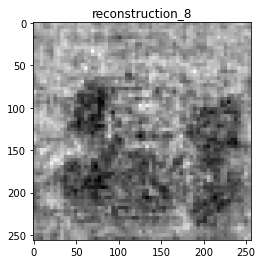

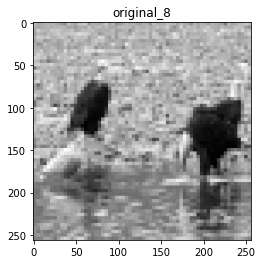

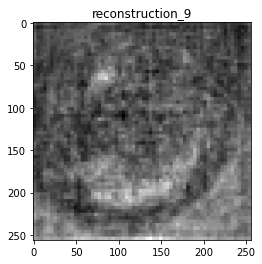

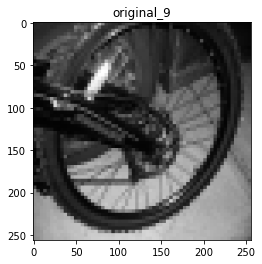

In [19]:
i=0
while i<10:
    test_output_validation = ridge.predict(retina_responses_validation[i].reshape((1,64*64)))

    plt.imshow(test_output_validation[0].reshape((256,256)), cmap='gray')
    plt.title('reconstruction_'+str(i))
    plt.show()

    plt.imshow(test_imgs_validation[i].reshape((256,256)), cmap='gray')
    plt.title('original_'+str(i))
    plt.show()
    
    i+=1

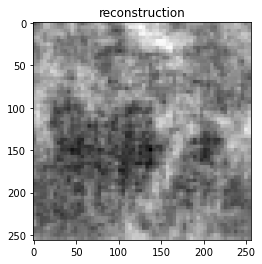

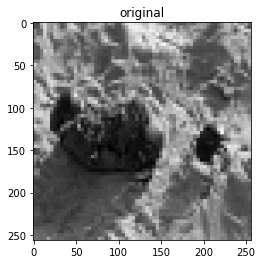

In [28]:
ridge_1000 = Ridge().fit(retina_responses_1000[0:999], test_imgs_1000[0:999])
test_output_ridge = ridge_1000.predict(retina_responses_1000[999].reshape((1,64*64)))

plt.imshow(test_output_ridge[0].reshape((256,256)), cmap='gray')
plt.title('reconstruction')
plt.show()

plt.imshow(test_imgs_1000[999].reshape((256,256)), cmap='gray')
plt.title('original')
plt.show()

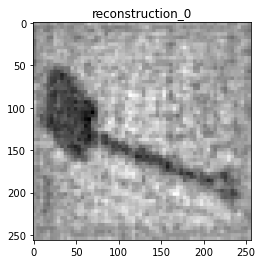

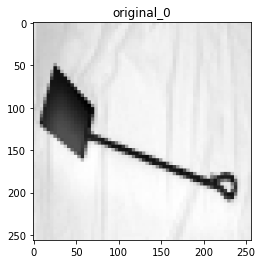

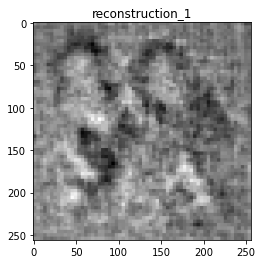

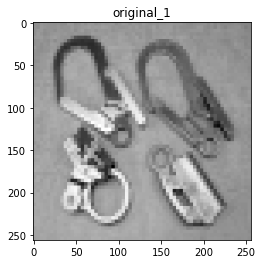

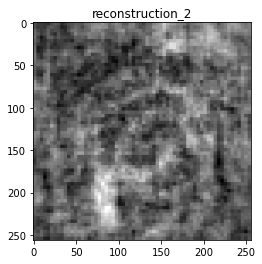

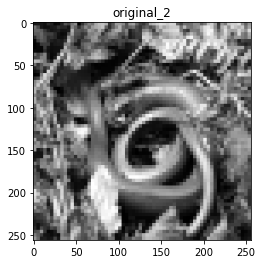

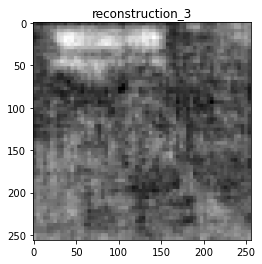

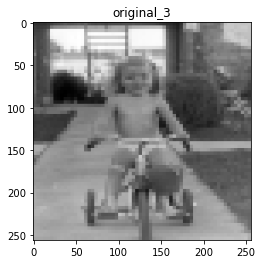

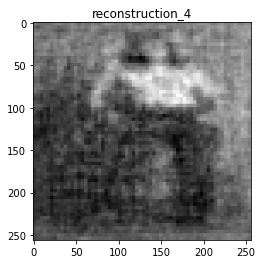

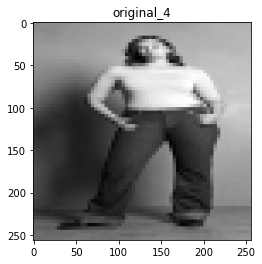

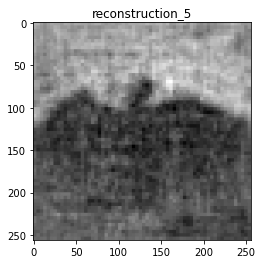

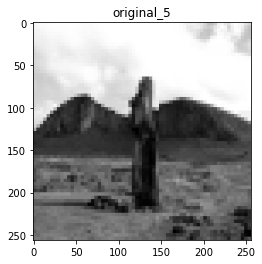

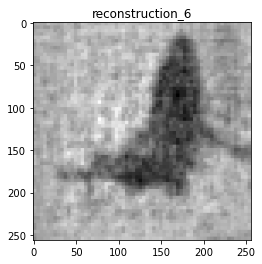

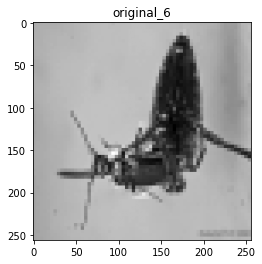

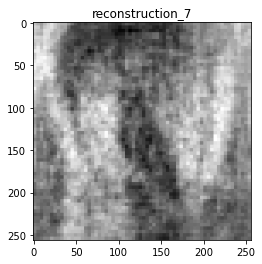

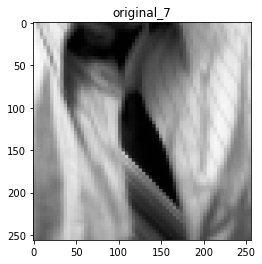

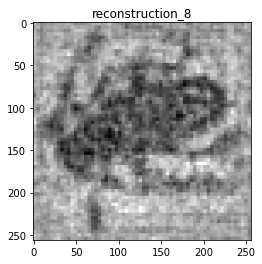

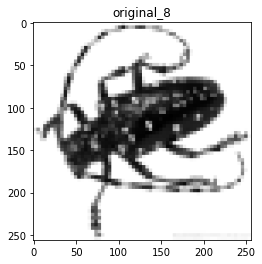

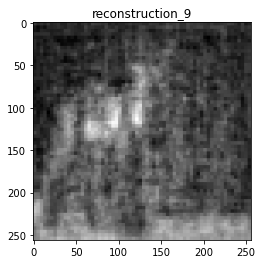

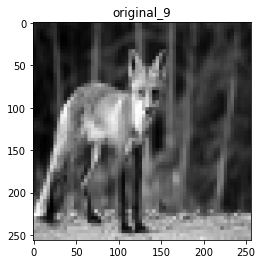

In [29]:
i=0
while i<10:
    test_output_validation = ridge_1000.predict(retina_responses_validation_1000[i].reshape((1,64*64)))

    plt.imshow(test_output_validation[0].reshape((256,256)), cmap='gray')
    plt.title('reconstruction_'+str(i))
    plt.show()

    plt.imshow(test_imgs_validation_1000[i].reshape((256,256)), cmap='gray')
    plt.title('original_'+str(i))
    plt.show()
    
    i+=1